<a href="https://colab.research.google.com/github/Lance-Gamier/Particle-Physics-Codes/blob/main/CERN_Find_the_Z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introductory steps

In [ ]:
!pip install awkward-pandas

In [ ]:
!pip install uproot

In [ ]:
import urllib.request # for downloading files
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting

In [ ]:
filename = 'data_A.exactly2lep.root'
url = 'https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/exactly2lep/Data/' + filename
urllib.request.urlretrieve(url, filename)

('data_A.exactly2lep.root', <http.client.HTTPMessage at 0x7f773c945b50>)

In [ ]:
import uproot

file = uproot.open("/content/data_A.exactly2lep.root")

file.keys()

['mini;1']

# Calculate the invariant mass

In [ ]:
def calc_mll(lep_pt, lep_eta, lep_phi, lep_E):

  sum_E = lep_E[0] + lep_E[1]

  px_0 = lep_pt * np.cos(lep_phi[0])
  py_0 = lep_pt * np.sin(lep_phi[0])
  pz_0 = lep_pt * np.sinh(lep_eta[0])

  px_1 = lep_pt * np.cos(lep_phi[1])
  py_1 = lep_pt * np.sin(lep_phi[1])
  pz_1 = lep_pt * np.sinh(lep_eta[1])

  sumpx = px_0 + px_1
  sumpy = py_0 + py_1
  sumpz = pz_0 + py_1

  Mll = sum_E**2 - (sumpx**2 + sumpy**2 + sumpz**2)

  return np.sqrt(np.maximum(Mll, 0)) / 1000

# Process the Data

# Function to plot Data

In [ ]:
import numpy as np
import awkward as ak

data_all = pd.DataFrame()
tree = uproot.open(filename)["mini"]
numevents = tree.num_entries

for data in tree.iterate(
    ["lep_pt", "lep_eta", "lep_phi", "lep_E"],
    library="ak",
    entry_stop=int(numevents * 0.001),
):
    # Filter for events with exactly 2 leptons
    # mask = ak.num(data["lep_pt"]) == 2
    # data = data[mask]

    # Zip the arrays together
    zipped = ak.zip({
        "lep_pt": data["lep_pt"],
        "lep_eta": data["lep_eta"],
        "lep_phi": data["lep_phi"],
        "lep_E": data["lep_E"],
    })

    # Apply calc_mll to each event
    mll_values = ak.Array([calc_mll(ev["lep_pt"], ev["lep_eta"], ev["lep_phi"], ev["lep_E"]) for ev in zipped])

    # Convert to DataFrame
    df = ak.to_dataframe({"mll": mll_values})
    data_all = pd.concat([data_all, df], ignore_index=True)

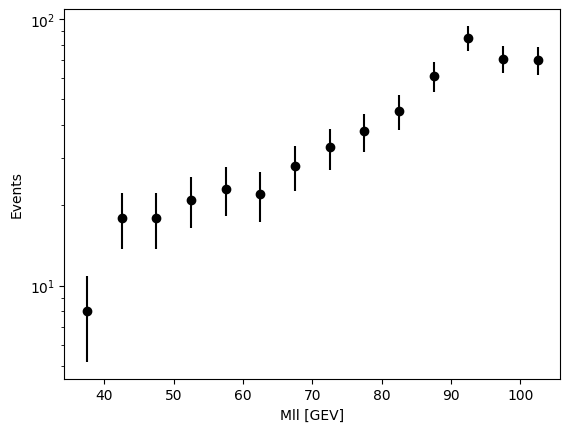

In [ ]:
bin_edges = np.arange(start = 35, stop = 110, step = 5)

bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

data_x,_ = np.histogram(data_all['mll'], bins = bin_edges)

data_x_errors = np.sqrt(data_x)

plt.errorbar(x = bin_centres, y = data_x, yerr = data_x_errors, fmt = 'ko')

plt.xlabel('Mll [GEV]')
plt.ylabel('Events')
plt.yscale('log')